In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

%matplotlib inline

In [2]:
df = pd.read_csv('sentiment labelled sentences/imdb_labelled.txt', delimiter='\t', header=None)

df.columns = ['review', 'score']
df['review'] = df['review'].str.lower()
df['review'] = df['review'].str.replace('.', ' ')
df['review'] = df['review'].str.replace(',', ' ')
df['review'] = df['review'].str.replace('!', ' ')

from nltk.corpus import stopwords
stop = stopwords.words('english')

words = df['review'].str.split().apply(lambda x: [item for item in x if item not in stop])

#score - bad is 0, good is 1

#turning score column into boolean - where True is BAD.
#Don't run this column more than once!!! otherwise everything False
df['score'] = (df['score'] == 0)

In [3]:
np.sum(df['score']==True)/np.sum(df['score']==False)

0.9378238341968912

This indicates that there is no class imbalace since there are an equal number of good and bad reviews and there is not a significant difference between one or the other. 

In [4]:
df.head()

,review,score
0,a very very very slow-moving aimless movie ...,True
1,not sure who was more lost - the flat characte...,True
2,attempting artiness with black & white and cle...,True
3,very little music or anything to speak of,True
4,the best scene in the movie was when gerardo i...,False


In [5]:
bad = np.where(df['score'] == True)
good = np.where(df['score'] == False)

In [6]:
from collections import Counter 

n = 150

Counter_bad = Counter(np.concatenate(np.asanyarray((words.iloc[bad])))) 
  
# most_common() produces n frequently encountered 
# input values and their respective counts. 
most_occur_bad = np.asanyarray(Counter_bad.most_common(n))
bad_words = most_occur_bad[:,0]


Counter_good = Counter(np.concatenate(np.asanyarray((words.iloc[good])))) 
most_occur_good = np.asanyarray(Counter_good.most_common(n))
good_words = most_occur_good[:,0]

In [7]:
keywords = []

for i in bad_words:
    dup_found = False
    for j in good_words:
        if i == j:
            dup_found = True
    if not dup_found:
        keywords.append(i)

In [8]:
#chose these keywords based off of words that you might find most likely to be in a bad yelp review
for key in keywords:
    df[str(key)] = df.review.str.contains(str(key), case=False)

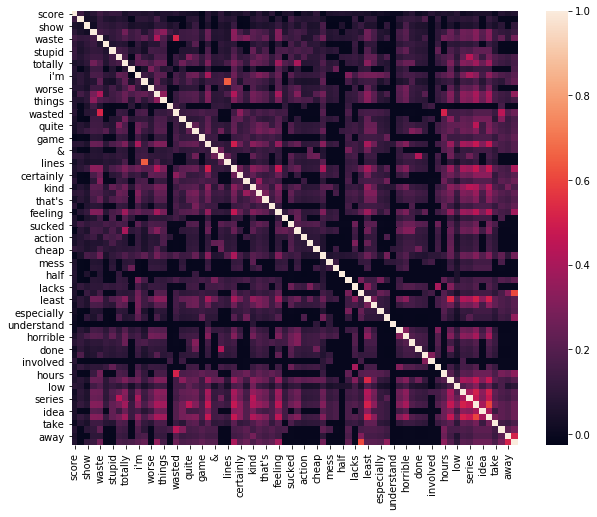

In [9]:
#making sure that my features are relatively independent of eachother.
plt.figure(figsize = (10,8))
sns.heatmap(df.corr())

plt.show()

In [10]:
#training data
data = df[keywords]
target = df['score']

In [11]:
#since the data is binary, import Bernoulli class
from sklearn.naive_bayes import BernoulliNB

#instantiate our model and store it in a new variable
bnb = BernoulliNB()

#fit model to data
bnb.fit(data, target)

#classify, storing the result in a new variable
y_pred = bnb.predict(data)

#displaying results
print('Number of mislabeled points out of a total {} points : {}'.format(data.shape[0], (target != y_pred).sum()))

print('{}% mislabeled'.format((target != y_pred).sum()/data.shape[0]*100))

# Calculate the accuracy of your model here.
print('Number of correctly identified points out of a total {} points : {}'.format(
    data.shape[0], 
    (target == y_pred).sum()
))

print('Accuracy = {:.4}%'.format((target == y_pred).sum()/data.shape[0]*100))

from sklearn.metrics import confusion_matrix
mat = confusion_matrix(target, y_pred)
false_pos = mat[1][0]
false_neg = mat[0][1]
specificity = mat[0][0]/sum(mat[0])
sensitivity = mat[1][1]/sum(mat[1])

print('confustion matrix: \n {}'.format(mat))
print('false positives: {}'.format(false_pos))
print('false negatives: {}'.format(false_neg))
print('sensitivity: {:.4}%'.format(sensitivity*100))
print('specificity: {:.4}%'.format(specificity*100))

Number of mislabeled points out of a total 748 points : 226
30.213903743315505% mislabeled
Number of correctly identified points out of a total 748 points : 522
Accuracy = 69.79%
confustion matrix: 
 [[357  29]
 [197 165]]
false positives: 197
false negatives: 29
sensitivity: 45.58%
specificity: 92.49%


In [12]:
from sklearn.model_selection import cross_val_score
cross_validation = cross_val_score(bnb, data, target, cv=10)

print(cross_validation)
print('mean: {}%'.format(np.mean(cross_validation)*100))
print('standard deviation: {}%'.format(np.std(cross_validation)*100))

[0.61842105 0.56578947 0.62666667 0.68       0.66666667 0.54666667
 0.71621622 0.66216216 0.63513514 0.64864865]
mean: 63.66372688477953%
standard deviation: 4.843378227765786%


In [13]:
# Implement your own cross validation with your spam model.
def cross_validation(fit, data, target, k):
    from sklearn.metrics import confusion_matrix

    #fit = bnb
    #k = number of folds - must be a value that allows equal split
    
    rand_data = data.sample(frac=1)
    n_data = np.split(rand_data, indices_or_sections=k)
    
    vals = []
    matrices = []
    
    for i in range(len(n_data)):
        index = n_data[i].index
        
        test_data = data.drop(index, axis=0)
        test_target = target.drop(index, axis=0)
        vals.append(bnb.fit(test_data, test_target).score(n_data[i], target[index]))
        
        y_pred = bnb.predict(n_data[i])
        matrices.append(confusion_matrix(target[index], y_pred))
        
    return vals, matrices

In [18]:
k = 11
cross_val = cross_validation(bnb, data, target, k)

print(cross_val[0])
print('mean: {}%'.format(np.mean(cross_val[0])*100))
print('standard deviation: {}%'.format(np.std(cross_val[0])*100))

for i in range(k):
    mat = cross_val[1][i]
    false_pos = mat[1][0]
    false_neg = mat[0][1]
    specificity = mat[0][0]/sum(mat[0])
    sensitivity = mat[1][1]/sum(mat[1])
    
    print('k = {}'.format(i))
    print('accuracy: {}%'.format(cross_val[0][i]*100))
    print('confustion matrix: \n {}'.format(mat))
    print('false positives: {}'.format(false_pos))
    print('false negatives: {}'.format(false_neg))
    print('sensitivity: {:.4}%'.format(sensitivity*100))
    print('specificity: {:.4}%'.format(specificity*100))
    print('\n')

[0.6617647058823529, 0.6470588235294118, 0.6470588235294118, 0.6029411764705882, 0.7058823529411765, 0.5735294117647058, 0.7205882352941176, 0.6764705882352942, 0.6176470588235294, 0.6470588235294118, 0.6323529411764706]
mean: 64.83957219251336%
standard deviation: 4.085750478592549%
k = 0
accuracy: 66.17647058823529%
confustion matrix: 
 [[31  1]
 [22 14]]
false positives: 22
false negatives: 1
sensitivity: 38.89%
specificity: 96.88%


k = 1
accuracy: 64.70588235294117%
confustion matrix: 
 [[26  5]
 [19 18]]
false positives: 19
false negatives: 5
sensitivity: 48.65%
specificity: 83.87%


k = 2
accuracy: 64.70588235294117%
confustion matrix: 
 [[32  7]
 [17 12]]
false positives: 17
false negatives: 7
sensitivity: 41.38%
specificity: 82.05%


k = 3
accuracy: 60.29411764705882%
confustion matrix: 
 [[33  4]
 [23  8]]
false positives: 23
false negatives: 4
sensitivity: 25.81%
specificity: 89.19%


k = 4
accuracy: 70.58823529411765%
confustion matrix: 
 [[35  5]
 [15 13]]
false positives:

# Testing the other data

In [19]:
df1 = pd.read_csv('sentiment labelled sentences/yelp_labelled.txt', delimiter='\t', header=None)

df1.columns = ['review', 'score']
df1['review'] = df1['review'].str.lower()
#score - bad is 0, good is 1

#turning score column into boolean - where True is BAD.
#Don't run this column more than once!!! otherwise everything False
df1['score'] = (df1['score'] == 0)

#chose these keywords based off of words that you might find most likely to be in a bad yelp review
for key in keywords:
    df1[str(key)] = df1.review.str.contains(str(key), case=False)

data1 = df1[keywords]   
target1 = df1['score']  
    
#classify, storing the result in a new variable
y_pred1 = bnb.predict(data1)

#displaying results
print('Number of mislabeled points out of a total {} points : {}'.format(data1.shape[0], (target1 != y_pred1).sum()))

print('{}% mislabeled'.format((target1 != y_pred1).sum()/data1.shape[0]*100))

# Calculate the accuracy of your model here.
print('Number of correctly identified points out of a total {} points : {}'.format(
    data1.shape[0], 
    (target1 == y_pred1).sum()
))

print('Accuracy = {:.4}%'.format((target1 == y_pred1).sum()/data1.shape[0]*100))

from sklearn.metrics import confusion_matrix
mat1 = confusion_matrix(target1, y_pred1)
false_pos = mat1[1][0]
false_neg = mat1[0][1]
specificity = mat1[0][0]/sum(mat1[0])
sensitivity = mat1[1][1]/sum(mat1[1])

print('confustion matrix: \n {}'.format(mat1))
print('false positives: {}'.format(false_pos))
print('false negatives: {}'.format(false_neg))
print('sensitivity: {:.4}%'.format(sensitivity*100))
print('specificity: {:.4}%'.format(specificity*100))

Number of mislabeled points out of a total 1000 points : 404
40.400000000000006% mislabeled
Number of correctly identified points out of a total 1000 points : 596
Accuracy = 59.6%
confustion matrix: 
 [[461  39]
 [365 135]]
false positives: 365
false negatives: 39
sensitivity: 27.0%
specificity: 92.2%


In [20]:
df2 = pd.read_csv('sentiment labelled sentences/amazon_cells_labelled.txt', delimiter='\t', header=None)

df2.columns = ['review', 'score']
df2['review'] = df2['review'].str.lower()
#score - bad is 0, good is 1

#turning score column into boolean - where True is BAD.
#Don't run this column more than once!!! otherwise everything False
df2['score'] = (df2['score'] == 0)

#chose these keywords based off of words that you might find most likely to be in a bad yelp review
for key in keywords:
    df2[str(key)] = df2.review.str.contains(str(key), case=False)

data2 = df2[keywords]   
target2 = df2['score']  
    
#classify, storing the result in a new variable
y_pred2 = bnb.predict(data2)

#displaying results
print('Number of mislabeled points out of a total {} points : {}'.format(data1.shape[0], (target2 != y_pred2).sum()))

print('{}% mislabeled'.format((target2 != y_pred2).sum()/data2.shape[0]*100))

# Calculate the accuracy of your model here.
print('Number of correctly identified points out of a total {} points : {}'.format(
    data2.shape[0], 
    (target2 == y_pred2).sum()
))

print('Accuracy = {:.4}%'.format((target2 == y_pred2).sum()/data2.shape[0]*100))

from sklearn.metrics import confusion_matrix
mat2 = confusion_matrix(target2, y_pred2)
false_pos = mat2[1][0]
false_neg = mat2[0][1]
specificity = mat2[0][0]/sum(mat2[0])
sensitivity = mat2[1][1]/sum(mat2[1])

print('confustion matrix: \n {}'.format(mat2))
print('false positives: {}'.format(false_pos))
print('false negatives: {}'.format(false_neg))
print('sensitivity: {:.4}%'.format(sensitivity*100))
print('specificity: {:.4}%'.format(specificity*100))

Number of mislabeled points out of a total 1000 points : 413
41.3% mislabeled
Number of correctly identified points out of a total 1000 points : 587
Accuracy = 58.7%
confustion matrix: 
 [[448  52]
 [361 139]]
false positives: 361
false negatives: 52
sensitivity: 27.8%
specificity: 89.6%
